# Metadata, QA, QC

The purpose of this notebook is for ensuring the `modis_wrf_aligned` dataset meets SNAPs standards for metadata, quality assurance, and quality control. 

# Metadata questionnaire

Re-create SNAP's metadata questionnaire.

Timestamp:

In [1]:
from datetime import datetime
print("Created on: {}".format(datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")))

Created on: 2021-01-06 23:04:06


## Time & place

#### Description of Geographic Extent

Rectangular polygon about 849 km (EW) by 262 km (NS) covering Interior Alaska.

#### Place keywords

Alaska, Interior, Chena River, White Mountains, CRSRA, WMNRA

#### Bounding coordinates

List bounding coordinates of output data:

In [2]:
import os, glob, datetime
import numpy as np
import pandas as pd
import rasterio as rio
import xarray as xr
from osgeo import gdal
from rasterio.crs import CRS
from rasterio.plot import show
from rasterio.warp import transform_bounds

In [3]:
out_dir = os.path.join(os.getenv("OUTPUT_DIR"), "aligned-WRF-MODIS")
# WRF sample output file
wrf_fp = sorted(glob.glob(os.path.join(out_dir, "WRF", "*")))[0]
with rio.open(wrf_fp) as src:
    wrf_bounds = src.bounds
    wrf_crs = src.crs
    wrf_meta = src.meta

# MODIS sample output file
mod_fp = sorted(glob.glob(os.path.join(out_dir, "MODIS", "*")))[0]
with rio.open(mod_fp) as src:
    mod_bounds = src.bounds
    mod_crs = src.crs
    mod_meta = src.meta
    
# ensure WRF and MODIS bounds are equal
print(
    "WRF and MODIS bounds are equal:", 
    np.all(wrf_bounds == mod_bounds), 
    "\n"
)

# print bounds
bb = transform_bounds(wrf_crs, CRS.from_epsg(4326), *wrf_bounds)
print("Western bound:", round(bb[0], 4))
print("Southern bound:", round(bb[1], 4))
print("Eastern bound:", round(bb[2], 4))
print("Northern bound:", round(bb[3], 4))

WRF and MODIS bounds are equal: True 

Western bound: -150.0616
Southern bound: 63.5695
Eastern bound: -142.3748
Northern bound: 65.9425


#### Time period

Print time period for sub data set with longest time span:

In [4]:
with xr.open_dataset(mod_fp) as ds:
    dates = [str(ds.date.values[i]) for i in [0,-1]]
    dates = [date[:10] for date in dates]
    print(f"Start date: {dates[0]}")
    print(f"End date: {dates[1]}")

Start date: 2000-03-29
End date: 2020-05-16


## Origins

### Info

#### Who created the data? 
Kyle Redilla

#### Who owns the data?
Stephen Klobucar

#### Email
kmredilla@alaska.edu

#### Address
2158 Koyukuk St, Fairbanks, AK 99709

### Credit

#### Other organizations who should get credit?
Peter Bieniek

## About

#### Abstract

8-day MODIS Land Surface Temperature (MOD11A2, MYD11A2) and WRF-downscaled ERA-Interim, GFDL-CM3, and NCAR-CCSM4 skin temperature data over Interior Alaska that have been aligned to the same grid and temporal timescale in EPSG:3338. This data set consists of two distinct sub data sets that share the exact same spatio-temporal gridding. The “WRF TSK” sub-data set is the result of extracting the skin temperature (TSK) data produced by dynamically downscaling each of ERA-Interim, GFDL-CM3, and NCAR-CCSM4 global models to a 1km resolution, aggregating daytime records by mean to match the temporal scale of the MODIS 8-day data products, and reprojecting to a shared CRS. The “MODIS LST” subdataset consists of 8-day MODIS land surface temperature data, from both Aqua and Terra satellites (MOD11A2 and MYD11A2), that has been reprojected and cropped to the extent of the reprojected WRF TSK data.

#### Keywords

Interior, Alaska, weekly, 8-day, surface temperature, skin temperature, MODIS, MOD11A2, MYD11A2, WRF, SERDP

#### Purpose

These data are intermediate for use with SERDP-funded research at UAF. 

#### File format

NetCDF

#### License

These data are not currently available for public use. 

#### Cross reference

TBD

## Methods

#### Protocols / methods used

The data pipeline ingesting the raw MODIS data consists of mosaicking, rescaling, and reprojecting, and clipping the MODIS to the extent of the WRF data. 

The data pipeline ingesting the raw WRF data consists of temporal resampling and reprojecting.

All of these methods are routine geospatial operations that should not need a specific reference.    

#### Analytical tools

`gdalwarp` is a command line tool for raster/image processing. It was used extensively in the creation of these data, specifically for mosaicking, reprojecting, warping, resampling, and cropping. Python was used for all other tasks. 

#### References

NA

#### Processing steps

The complete data processing is done by the code in the `pipeline/` sub-directory of this repository: https://github.com/ua-snap/modis_lst. A high-level overview of the processing steps corresponding to scripts in `pipeline/`: 
1. Mosaic MODIS data from separate tiles and reproject to EPSG:3338
2. Temporally aggregate WRF data via maximum to to match 8-day periods used in MODIS
3. Clip the mosaicked MODIS to the extent of the (reprojected template) WRF data
4. Reproject (downsample) the WRF data to the clipped MODIS grid

#### Base data

Downscaled GCM and Reanalysis data made available by Peter Bieniek (unpublished)
1979 - 2076, interior Alaska
NetCDF

MOD11A2, 2002-03-30 to 2020-05-16, state of Alaska, partial surrounding area.

* MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid. Zhengming Wan - University of California Santa Barbara, Simon Hook, Glynn Hulley - JPL and MODAPS SIPS - NASA. (2015). MOD11A2 MODIS/Terra Land Surface Temperature and the Emissivity 8-Day L3 Global 1km SIN Grid. NASA LP DAAC. http://doi.org/10.5067/MODIS/MOD11A2.006

MYD11A2, 2002-03-30 to 2020-05-16, state of Alaska, partial surrounding area.
* MODIS/Aqua Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid. Zhengming Wan - University of California Santa Barbara, Simon Hook, Glynn Hulley - JPL and MODAPS SIPS - NASA. (2015). MYD11A2 MODIS/Aqua Land Surface Temperature and the Emissivity 8-Day L3 Global 1km SIN Grid. NASA LP DAAC. http://doi.org/10.5067/MODIS/MYD11A2.006



## Data

All output files are structured in the same way. Thus, only one example will be used to show the relevant parts of the data for each of the following sections.

#### Entity

The NetCDF files have three dimensions and a data variable. The data variable is either "tsk" (WRF) or "lst" (MODIS), and the coordinate variables (and dimension names) are "xc", "yc", and "date". These variables correspond to the x and y coordinate in EPSG:3338, and the date is the first day of the 8-day MODIS period, in YYYY-mm-dd format.

In [5]:
with xr.open_dataset(wrf_fp) as ds:
    print(f"\n  Data variable atributes for {wrf_fp}:\n")
    print(ds[list(ds.variables)[0]])


  Data variable atributes for /home/kmredilla/projects/SERDP-fish-fire/data/aligned-WRF-MODIS/WRF/tsk_max_ccsm_2008-2017_aligned.nc:

<xarray.DataArray 'tsk' (date: 280, yc: 135, xc: 203)>
[7673400 values with dtype=float32]
Coordinates:
  * xc       (xc) float64 1.937e+05 1.954e+05 1.971e+05 ... 5.319e+05 5.336e+05
  * yc       (yc) float64 1.781e+06 1.78e+06 1.778e+06 ... 1.558e+06 1.556e+06
  * date     (date) datetime64[ns] 2008-03-29 2008-04-06 ... 2017-11-01
Attributes:
    long_name:     Surface skin temperature
    units:         Kelvin
    grid_mapping:  crs


#### Spatial reference

The coordinate reference system used is EPSG:3338. The spatial attributes are saved within the dummy variable called "crs":

In [6]:
with xr.open_dataset(wrf_fp) as ds:
    print(f"\n  Coordinate Reference System for {wrf_fp}:\n")
    print(ds.crs)


  Coordinate Reference System for /home/kmredilla/projects/SERDP-fish-fire/data/aligned-WRF-MODIS/WRF/tsk_max_ccsm_2008-2017_aligned.nc:

<xarray.DataArray 'crs' ()>
array(0, dtype=int16)
Attributes:
    crs_wkt:                        PROJCRS["NAD83 / Alaska Albers",BASEGEOGC...
    semi_major_axis:                6378137.0
    semi_minor_axis:                6356752.314140356
    inverse_flattening:             298.257222101
    reference_ellipsoid_name:       GRS 1980
    longitude_of_prime_meridian:    0.0
    prime_meridian_name:            Greenwich
    geographic_crs_name:            NAD83
    horizontal_datum_name:          North American Datum 1983
    projected_crs_name:             NAD83 / Alaska Albers
    grid_mapping_name:              albers_conical_equal_area
    standard_parallel:              [55. 65.]
    latitude_of_projection_origin:  50.0
    longitude_of_central_meridian:  -154.0
    false_easting:                  0.0
    false_northing:                 0.0


#### Attributes

Other metadata are provided as global attributes in the NetCDF files:

In [7]:
with xr.open_dataset(wrf_fp) as ds:
    print(f"  Global attributes for {wrf_fp}:\n")
    _ = [print(k, ds.attrs[k]) for k in ds.attrs]

  Global attributes for /home/kmredilla/projects/SERDP-fish-fire/data/aligned-WRF-MODIS/WRF/tsk_max_ccsm_2008-2017_aligned.nc:

title 1km MODIS-aligned WRF TSK
history 2020-12-16 03:36:09.175053 Python
Conventions CF-1.8
institution Scenarios Network for Alaska + Arctic Planning
contact kmredilla@alaska.edu
source NCAR-CCSM4 downscaled via WRF 4.0
version 1.0.0
comment Intended for use with SERDP research on fish and fire in Alaskan boreal forests


## Quality Assurance

Demonstrate functionality and performance across common platforms, tools and services.

### GDAL

Using the ‘gdalinfo <file>’ function from command line, the file is readable and displays the file header information about the file dimensions, variables, and metadata. The Open and GetMetadata functions return non-empty values that correspond to the netCDF file contents. The GetProjection function (of the appropriate file) returns a non-empty result corresponding to the data coordinate reference system information.

Here we use the Python GDAL bindings insted of the GDAL CLI.

In [12]:
def test_gdal(fp):
    dataset = gdal.Open(fp, gdal.GA_ReadOnly)
    
    if dataset is not None:
        print("GDALOpen successful.")
    else:
        exit(f"GDALOpen failed for {fp}")
    
    print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
                                dataset.GetDriver().LongName))
    print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                        dataset.RasterYSize,
                                        dataset.RasterCount))
    
    projection = dataset.GetProjection()
    if projection is not None:
        print(f"\nGetProjection successful: \n{projection}")
    else:
        exit(f"GetProjection failed for {fp}")
        
    geotransform = dataset.GetGeoTransform()
    if geotransform:
        print("\nOrigin = ({}, {})".format(geotransform[0], geotransform[3]))
        print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))
    
    metadata = dataset.GetMetadata()
    if metadata is not None:
        print("\nGetMetadata successful")
    else:
        exit(f"GetMetadata failed for {fp}")

Sample WRF file:

In [13]:
test_gdal(wrf_fp)

GDALOpen successful.
Driver: netCDF/Network Common Data Format
Size is 203 x 135 x 280

GetProjection successful: 
PROJCS["unnamed",GEOGCS["unknown",DATUM["unnamed",SPHEROID["Spheroid",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",50],PARAMETER["longitude_of_center",-154],PARAMETER["standard_parallel_1",55],PARAMETER["standard_parallel_2",65],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]

Origin = (192899.8482943459, 1782191.9692347285)
Pixel Size = (1682.4679725100275, -1682.4679725100268)

GetMetadata successful


Sample MODIS file:

In [14]:
test_gdal(mod_fp)

GDALOpen successful.
Driver: netCDF/Network Common Data Format
Size is 203 x 135 x 566

GetProjection successful: 
PROJCS["unnamed",GEOGCS["unknown",DATUM["unnamed",SPHEROID["Spheroid",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",50],PARAMETER["longitude_of_center",-154],PARAMETER["standard_parallel_1",55],PARAMETER["standard_parallel_2",65],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]

Origin = (192899.8482943459, 1782191.9692347285)
Pixel Size = (1682.4679725100275, -1682.4679725100268)

GetMetadata successful


### Python

Files open with `xarray` and `rasterio`. See above and `./validation.ipynb` for more checks.

### Plots, summaries, other validation.

Pass. See `./validation.ipynb` for more checks.

## Quality Control

### File headers

Files mostly adhere to Climate Forecasting convention. Given these data are for internal use, strict validation of CF convention adherence is not required.

### Metadata validation 

Given these data are for internal use, no metadata files are required for this project.

### Missing data

Both aligned data sets (WRF and MODIS) have missing data. There are also gaps in the time series where data that was not needed for modelling (winter months) was discarded.

WRF data should have no missing data except for outside of the modeling domain. Check that the missing data cells in the WRF files are the same cells for all files. 

In [8]:
# all WRF output files
wrf_fps = sorted(glob.glob(os.path.join(out_dir, "WRF", "*")))

# iterate through all time slices and find missing data indices, test all equal
arr = np.concatenate([xr.load_dataset(fp).tsk.values for fp in wrf_fps])
# iterate to compare all arrays
iterator = iter([np.where(np.isnan(sl)) for sl in arr])
first = next(iterator)
result = all(np.array_equal(first, rest) for rest in iterator)

print("Missing data is consistent across all WRF files: ", result)

Missing data is consistent across all WRF files:  True


### Consistent null values

NaN was used for the missing data / null values. Verify that all non-NaN data is within a given range.

Print the non-NaN ranges for all files:

In [9]:
mod_fps = sorted(glob.glob(os.path.join(out_dir, "MODIS", "*")))
all_fps = wrf_fps + mod_fps

arrs = [
    xr.load_dataset(fp)[os.path.basename(fp)[:3]].values 
    for fp in all_fps
]

def get_range(arr):
    return (round(np.nanmin(arr), 1), round(np.nanmax(arr), 1))

ranges = [get_range(arr) for arr in arrs]

_ = [
    print(f"{os.path.basename(fp)}: ", valid_range) 
    for fp, valid_range in zip(all_fps, ranges)
]

tsk_max_ccsm_2008-2017_aligned.nc:  (245.0, 313.0)
tsk_max_ccsm_2038-2047_aligned.nc:  (248.1, 318.6)
tsk_max_ccsm_2068-2077_aligned.nc:  (244.6, 328.2)
tsk_max_era_2000-2018_aligned.nc:  (240.1, 304.7)
tsk_max_gfdl_2008-2017_aligned.nc:  (248.5, 305.6)
tsk_max_gfdl_2038-2047_aligned.nc:  (253.3, 310.2)
tsk_max_gfdl_2068-2077_aligned.nc:  (254.0, 313.6)
lst_MOD11A2_aligned.nc:  (234.3, 330.8)
lst_MYD11A2_aligned.nc:  (235.5, 341.3)


Ranges all appear reasonable.

### Geospatial reference check

Plot a single georeferenced time slice from sample WRF and MODIS files.

WRF:

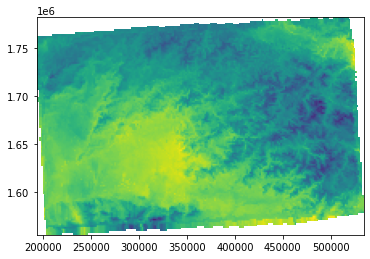

In [10]:
with rio.open(wrf_fp) as src:
    show(src.read(1), transform=src.transform)

MODIS

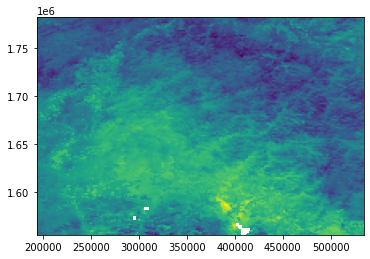

In [11]:
with rio.open(mod_fp) as src:
    show(src.read(1), transform=src.transform)

For more checks, see `./validation.ipynb`. 

### Outliers and value errors

See "Consistent null values" section above. All values appear within reasonable range. See `./validation.ipynb` for more checks.

### Threshold exceedances

See "Consistent null values" and "Outliers and value errors" sections above. All values appear within reasonable range. See `./validation.ipynb` for more checks.